<a href="https://colab.research.google.com/github/malloyca/CSC581B/blob/main/Final%20Project/vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC581B - Deep Learning for Image Classification

# VGG-16 Implementation

In [1]:
# imports
import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import CIFAR100
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import numpy as np
import random


In [2]:
# This is to control the size of the VGG network
# Set to 7 to create the full sized VGG network (224x224 input)
# Set to  1 to set it up for the 32x32 CIFAR images
expansion_coef = 1 # set to int >= 1

In [5]:
# This will resize the images if expansion_coef > 1 (which makes things incredibly slow)
data_augmentation_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomRotation(degrees=30),
  transforms.RandomCrop(32, padding=2),
  transforms.ColorJitter(brightness=0.25, contrast=0.5, saturation=0.25, hue = 0.15),
  transforms.RandomGrayscale(p=0.2),
  transforms.Resize(size=32 * expansion_coef), # It'll be quicker if you resize last after all the augmentation transforms
  transforms.ToTensor(),
  transforms.Normalize(
      mean = [0.5071, 0.4867, 0.4408],
      std = [0.2675, 0.2565, 0.2761]
  ),
  transforms.RandomErasing(p=.35),
])

In [6]:
# This will resize the images if expansion_coef > 1
normalize_transform = transforms.Compose([
  transforms.Resize(size=32 * expansion_coef),
  transforms.ToTensor(),
  transforms.Normalize(
      mean = [0.5071, 0.4867, 0.4408],
      std = [0.2675, 0.2565, 0.2761]
  ),
])

## Load CIFAR-100

Load the dataset and split into training and test sets.

In [7]:
# Load the training data (CIFAR10 to start)
training_data_with_augmentation = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = data_augmentation_transform,
)

# Thisis to make it easier to compare augmentation vs no augmentation results
training_data_without_augmentation = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = normalize_transform,
)

# this is necessary to prevent the data augmentation transforms from being applied to the validation set
validation_data = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = normalize_transform,
)

# Load the test data
test_data = CIFAR100(
    root = "data",
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
training_targets = training_data_with_augmentation.targets

In [9]:
train_split_index, valid_split_index = train_test_split(
    np.arange(len(training_targets)), test_size=0.2, stratify=training_targets
)

In [10]:
batch_size = 100

# Create data loaders
train_augmentation_dataloader = DataLoader(training_data_with_augmentation, batch_size=batch_size,
                              sampler=SubsetRandomSampler(train_split_index))
train_no_augmentation_dataloader = DataLoader(training_data_without_augmentation, batch_size=batch_size,
                              sampler=SubsetRandomSampler(train_split_index))
valid_dataloader = DataLoader(validation_data, batch_size=batch_size,
                              sampler=SubsetRandomSampler(valid_split_index))
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [11]:
# Set to True to skip the dataset checks (they slow things down when doing 'run all')
train_status = True

In [12]:
if not train_status:
  # Check that it is splitting the data properly
  train_length = 0
  for _, y in train_augmentation_dataloader:
    train_length += len(y)
  print(f"Length of training (augmentation) split: {train_length}")

  train_aug_length = 0
  for _, y in train_no_augmentation_dataloader:
    train_aug_length += len(y)
  print(f"Length of training (no augmentation) split: {train_aug_length}")

  valid_length = 0
  for _, y in valid_dataloader:
    valid_length += len(y)
  print(f"Length of validation split: {valid_length}")

  test_length = 0
  for _, y in test_dataloader:
    test_length += len(y)
  print(f"Length of test split: {test_length}")

In [13]:
if not train_status:
  # Check that there are 100 instances of a random class in the validation set
  count = 0
  test_class = random.randint(0,99)
  for _, y in valid_dataloader:
    for target in y:
      if int(target.numpy()) == test_class:
        count += 1

  print(count)

# Building VGG-16

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## The architecture (from the paper https://arxiv.org/pdf/1409.1556.pdf)

Notes:
- conv3 = 3x3 convolutional layer
  - stride = 1
  - pad = 1
- maxpool 2x2
  - stride = 2
- weight decay (L2 reg) = 5e-4
- Dropout on first two FC layers
  - ratio = 0.5
- LR = 1e-2
  - decreased by factor of ten on plateau
- batch size = 256

The architecture:
- Input: 224 x 224 RGB (32x32 for CIFAR100  or can resize CIFAR images to 224x224)
- Block 1
  - conv3-64
  - conv3-64
  - maxpool
- block 2
  - conv3-128
  - conv3-128
  - maxpool
- block 3
  - conv3-256
  - conv3-256
  - conv3-256
  - maxpool
- block 4
  - conv3-512
  - conv3-512
  - conv3-512
  - maxpool
- block 5
  - conv3-512
  - conv3-512
  - conv3-512
  - maxpool
- fully connected - 4096
- fully connected - 4096
- fully connected - 1000 (1000 is for ImageNet, we would need 100 for CIFAR)
- softmax



In [15]:
# Define the model
class VGG16(nn.Module):
  def __init__(self, expansion_coef):
    super(VGG16, self).__init__()
    self.name = 'VGG-16'
    self.expansion_coef = expansion_coef

    self.layers = nn.Sequential(
        # Block 1 shape: 224x224
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Block 2 shape: 112x112
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Block 3 shape: 56x56
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Block 4 shape: 28x28
        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Block 5 shape: 14x14
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Block 6 shape: 7x7 / this is 1x1 if expansion_coef = 1
        nn.Flatten(),
        nn.Linear(512* self.expansion_coef * self.expansion_coef,4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 100)
    )


  def forward(self, x):
    x = self.layers(x)
    return x

In [24]:
# In the paper they talk about initializing the weights and say that pre-training is not necessary if you
# initialize the weights according to the paper by Glorot & Bengio, aka Xavier initialization (I'm using the uniform version)
def initialize_weights(layer):
  if isinstance(layer, nn.Conv2d):
    nn.init.xavier_uniform_(layer.weight)
    layer.bias.data.fill_(0.01)

In [16]:
# Training function
def train(dataloader, batch_size, model, loss_fn, optimizer):
  num_batches = len(dataloader)
  size = num_batches * batch_size
  model.train()
  train_loss, num_correct = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track train_loss and accuracy
    train_loss += loss.item()
    num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

  train_loss /= num_batches
  accuracy = num_correct / size
  return train_loss, accuracy

In [17]:
# Validation function
def validation(dataloader, batch_size, model, loss_fn):
  num_batches = len(dataloader)
  size = num_batches * batch_size
  model.eval()
  val_loss, num_correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      val_loss += loss_fn(pred, y).item()
      num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  val_loss /= num_batches
  accuracy = num_correct / size
  print(f"Validation Error: \n Validation accuracy: {(100 * accuracy):>0.1f}%, Validation loss: {val_loss:>8f} \n")
  return val_loss, accuracy

In [18]:
# Test function
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return test_loss

In [19]:
def training_loop(n_epochs, model, train_data, valid_data, batch_size,
                  loss_function, optimizer, scheduler=None,
                  early_stopping=False, patience=10):
  current_epoch = 0
  best_epoch = 0
  best_loss = float('inf')
  patience_counter = 0

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for e in range(n_epochs):
    print(f"\nEpoch {e+1}\n----------------------------")
    # Iterate epoch counter
    current_epoch += 1

    train_loss, train_accuracy = train(train_data, batch_size, model, loss_function, optimizer)
    val_loss, val_accuracy = validation(valid_data, batch_size, model, loss_function)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Iterate scheduler (this is set up for ReduceLROnPlateau)
    if scheduler is not None:
      scheduler.step(val_loss)

    # If early_stopping check test_loss
    if early_stopping:
      # case: test loss beats the current best loss
      if val_loss < best_loss:
        # store loss
        best_loss = val_loss

        # reset patience counter
        patience_counter = 0

        # store model and epoch number
        print("Storing new best model.")
        best_model_state_dict = copy.deepcopy(model.state_dict)
        best_epoch = current_epoch

      # Case: patience limit not yet reached => iterate patience counter
      elif patience_counter < patience - 1:
        patience_counter += 1
        print(f"Patience count: {patience_counter}")

      # Case: patience limit reached
      else:
        print("Finished due to early stopping.")
        print(f"Saving best model: {model.name}_epoch-{best_epoch:03d}")
        torch.save(best_model_state_dict, f'{model.name}_epoch-{best_epoch:03d}')
        break

  # If we get here, we did not stop early - save best model
  if early_stopping:
    print(f"Saving best model: {model.name}_epoch-{best_epoch:03d}")
    torch.save(best_model_state_dict, f'{model.name}_epoch-{best_epoch:03d}')
  else:
    print()

  return train_losses, train_accuracies, val_losses, val_accuracies

# Training

In [53]:
n_epochs = 100

In [54]:
model = VGG16(expansion_coef).to(device)
num_param = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {num_param:,}")

model_aug = VGG16(expansion_coef).to(device)
num_param = sum(p.numel() for p in model_aug.parameters())
print(f"Total number of parameters: {num_param:,}")

Total number of parameters: 34,006,948
Total number of parameters: 34,006,948


34M parameters when `expansion_coef = 1`. That's a lot. It's significantly larger when `expansion_coeff` is greater than 1.

In [55]:
# Apply initialization to the weights
model.apply(initialize_weights)
model_aug.apply(initialize_weights)
print() # to suppress model output

In [56]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer # they used SGD in the original paper since Adam didn't exist at the time
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=5e-5)


# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=5)
scheduler_aug = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_aug, mode='min', patience=5)

# Results for VGG

First without data augmentation

In [57]:
# No data augmentation
train_loss, train_accuracy, val_loss, val_accuracy = training_loop(
    n_epochs, model, train_no_augmentation_dataloader, valid_dataloader, batch_size,
    loss_fn, optimizer, scheduler, early_stopping=True, patience=20)


Epoch 1
----------------------------
loss: 4.605245 [    0/40000]
loss: 4.604267 [10000/40000]
loss: 4.601248 [20000/40000]
loss: 4.458972 [30000/40000]
Validation Error: 
 Validation accuracy: 2.2%, Validation loss: 4.445719 

Storing new best model.

Epoch 2
----------------------------
loss: 4.402304 [    0/40000]
loss: 4.378616 [10000/40000]
loss: 4.189282 [20000/40000]
loss: 4.035593 [30000/40000]
Validation Error: 
 Validation accuracy: 4.8%, Validation loss: 4.107325 

Storing new best model.

Epoch 3
----------------------------
loss: 4.076949 [    0/40000]
loss: 4.033335 [10000/40000]
loss: 4.090257 [20000/40000]
loss: 4.067828 [30000/40000]
Validation Error: 
 Validation accuracy: 6.0%, Validation loss: 3.978380 

Storing new best model.

Epoch 4
----------------------------
loss: 4.068161 [    0/40000]
loss: 4.047586 [10000/40000]
loss: 3.739238 [20000/40000]
loss: 3.642743 [30000/40000]
Validation Error: 
 Validation accuracy: 8.7%, Validation loss: 3.759503 

Storing new 

### LR test results
- `1e-1` => blows up
- `1e-2` => No learning
- `1e-3` => No learning
- `2e-4` => 7.1% / 3.908374
- `1e-4` => 6.7% / 3.903954
- `5e-5` => 6.8% / 3.891109

<function matplotlib.pyplot.show>

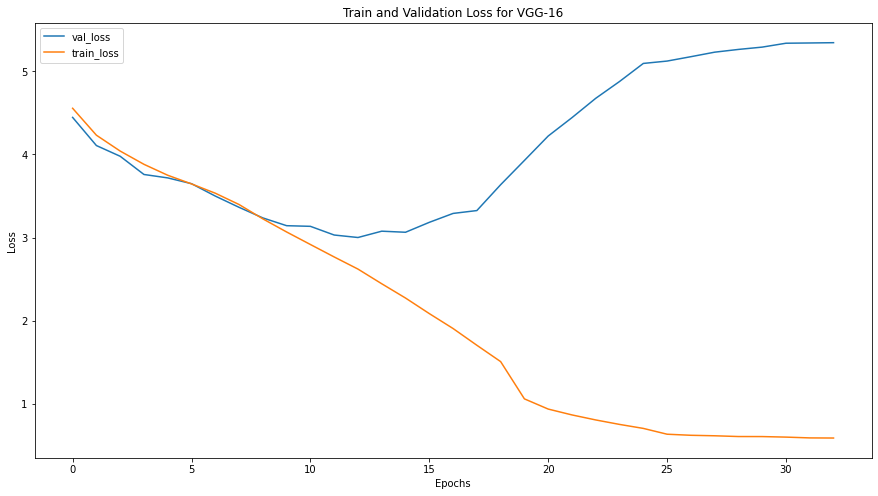

In [58]:
# plot loss
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Loss for {model.name}")
plt.plot(val_loss, label="val_loss")
plt.plot(train_loss, label="train_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

<function matplotlib.pyplot.show>

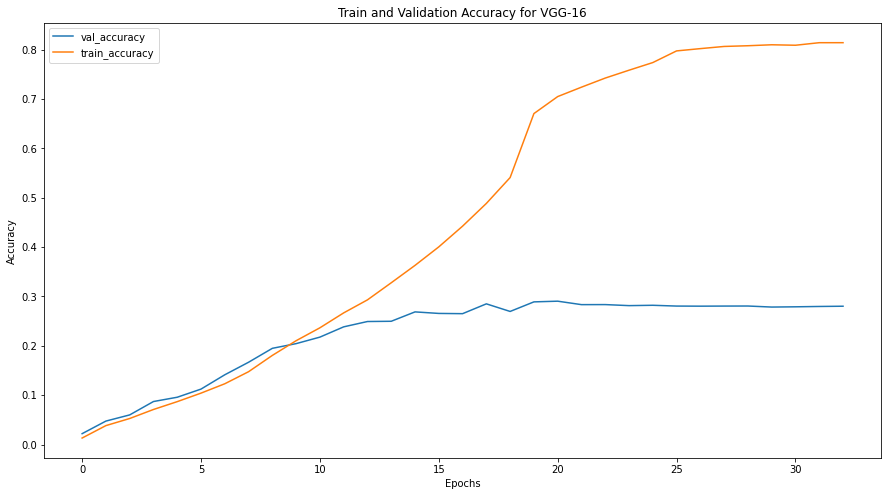

In [59]:
# plot accuracy
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Accuracy for {model.name}")
plt.plot(val_accuracy, label="val_accuracy")
plt.plot(train_accuracy, label="train_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show

Now with data augmentation

In [60]:
# With data augmentation
train_loss_aug, train_accuracy_aug, val_loss_aug, val_accuracy_aug = training_loop(
    n_epochs, model_aug, train_augmentation_dataloader, valid_dataloader, batch_size,
    loss_fn, optimizer_aug, scheduler_aug, early_stopping=True, patience=20)


Epoch 1
----------------------------
loss: 4.603636 [    0/40000]
loss: 4.605521 [10000/40000]
loss: 4.610398 [20000/40000]
loss: 4.489838 [30000/40000]
Validation Error: 
 Validation accuracy: 1.9%, Validation loss: 4.422615 

Storing new best model.

Epoch 2
----------------------------
loss: 4.481180 [    0/40000]
loss: 4.451550 [10000/40000]
loss: 4.528248 [20000/40000]
loss: 4.345903 [30000/40000]
Validation Error: 
 Validation accuracy: 4.2%, Validation loss: 4.197979 

Storing new best model.

Epoch 3
----------------------------
loss: 4.294763 [    0/40000]
loss: 4.269816 [10000/40000]
loss: 4.194230 [20000/40000]
loss: 4.236896 [30000/40000]
Validation Error: 
 Validation accuracy: 4.9%, Validation loss: 4.119652 

Storing new best model.

Epoch 4
----------------------------
loss: 4.283693 [    0/40000]
loss: 4.239899 [10000/40000]
loss: 4.422577 [20000/40000]
loss: 4.102037 [30000/40000]
Validation Error: 
 Validation accuracy: 5.7%, Validation loss: 3.989484 

Storing new 

<function matplotlib.pyplot.show>

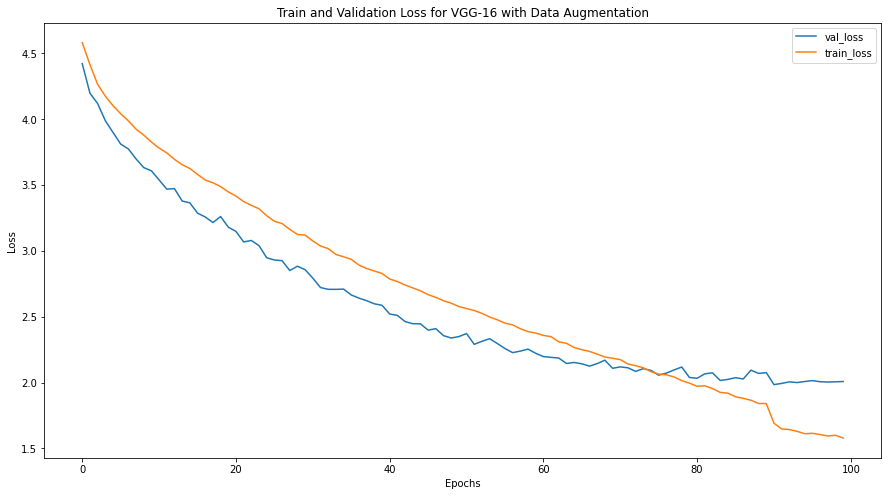

In [63]:
# plot loss
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Loss for {model_aug.name} with Data Augmentation")
plt.plot(val_loss_aug, label="val_loss")
plt.plot(train_loss_aug, label="train_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

<function matplotlib.pyplot.show>

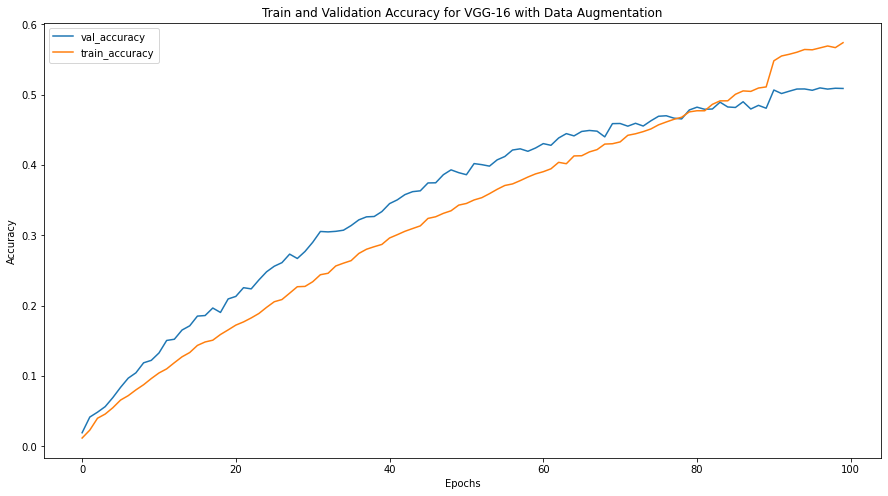

In [64]:
# plot accuracy
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Accuracy for {model_aug.name} with Data Augmentation")
plt.plot(val_accuracy_aug, label="val_accuracy")
plt.plot(train_accuracy_aug, label="train_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show